# CIFAR-10 Image Classification with Experiment Tracking
Track experiments for model improvements on CIFAR-10 dataset

In [81]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models

In [82]:
# Setup GPU device
import pandas as pd
from datetime import datetime
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

# Initialize experiment tracker
experiment_results = []

Using device: cuda
GPU: NVIDIA GeForce RTX 5090
Memory: 31.84 GB


In [98]:
# CIFAR-10 proper statistics (calculated from training set)
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2470, 0.2435, 0.2616)

# Training transforms with augmentation for better generalization
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random cropping with padding
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))  # Cutout augmentation
])

# Test transforms (no augmentation, just normalize)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training set: {len(trainset)} images")
print(f"Test set: {len(testset)} images")
print(f"Batch size: {batch_size}")
print(f"Augmentation: RandomCrop, HorizontalFlip, RandomErasing (Cutout)")

Training set: 50000 images
Test set: 10000 images
Batch size: 512
Augmentation: RandomCrop, HorizontalFlip, RandomErasing (Cutout)


Saved: ./plots/sample_training_images.png


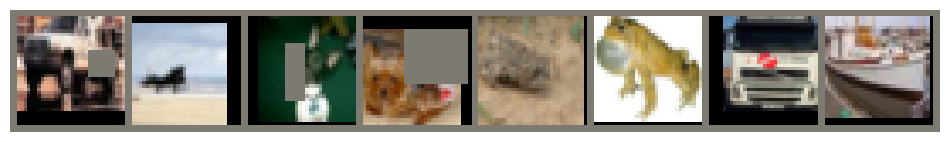

Labels: truck plane dog   dog   frog  frog  truck ship 


In [115]:
# Create plots directory if it doesn't exist
import os
os.makedirs('./plots', exist_ok=True)

def imshow(img, save_path=None):
    """Unnormalize and display image using CIFAR-10 statistics"""
    mean = torch.tensor(cifar10_mean).view(3, 1, 1)
    std = torch.tensor(cifar10_std).view(3, 1, 1)
    img = img * std + mean
    img = torch.clamp(img, 0, 1)  # Clamp to valid range
    npimg = img.numpy()
    plt.figure(figsize=(12, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show a smaller grid (8 images) since batch_size is large
num_show = min(8, batch_size)
imshow(torchvision.utils.make_grid(images[:num_show]), save_path='./plots/sample_training_images.png')
print('Labels: ' + ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_show)))

In [ ]:
# ResNet with LeakyReLU
class BasicBlockLeakyReLU(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.leaky_relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.leaky_relu(out)
        return out

class ResNetLeakyReLU(nn.Module):
    """ResNet with LeakyReLU activation - supports ResNet-18, 34, 50"""
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.in_channels = 64
        
        # CIFAR-10 adapted: smaller kernel, no maxpool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet18_leaky():
    """ResNet-18 with LeakyReLU - 11.2M params (PROVEN: 86% accuracy)"""
    return ResNetLeakyReLU(BasicBlockLeakyReLU, [2, 2, 2, 2])

def resnet34_leaky():
    """ResNet-34 with LeakyReLU - 21.3M params (DEEPER)"""
    return ResNetLeakyReLU(BasicBlockLeakyReLU, [3, 4, 6, 3])

# Choose depth:
use_deeper = True  # Set to False for ResNet-18 (proven 86%), True for ResNet-34 (deeper)

if use_deeper:
    net = resnet34_leaky()
    model_name = 'ResNet-34-LeakyReLU'
else:
    net = resnet18_leaky()
    model_name = 'ResNet-18-LeakyReLU'

net = net.to(device)
print(f'Model: {model_name}')
print(f'Device: {device}')
print(f'Total params: {sum(p.numel() for p in net.parameters()):,}')

Model: ResNet-34-LeakyReLU
Device: cuda
Total params: 21,282,122


## LR Range Test (Leslie Smith Method) - ENABLED BY DEFAULT
This cell automatically finds the optimal learning rate before training. Set `use_lr_finder = False` to skip.

Running LR Range Test with ResNet-34-LeakyReLU...
Stopping early at iteration 85 - loss exploded


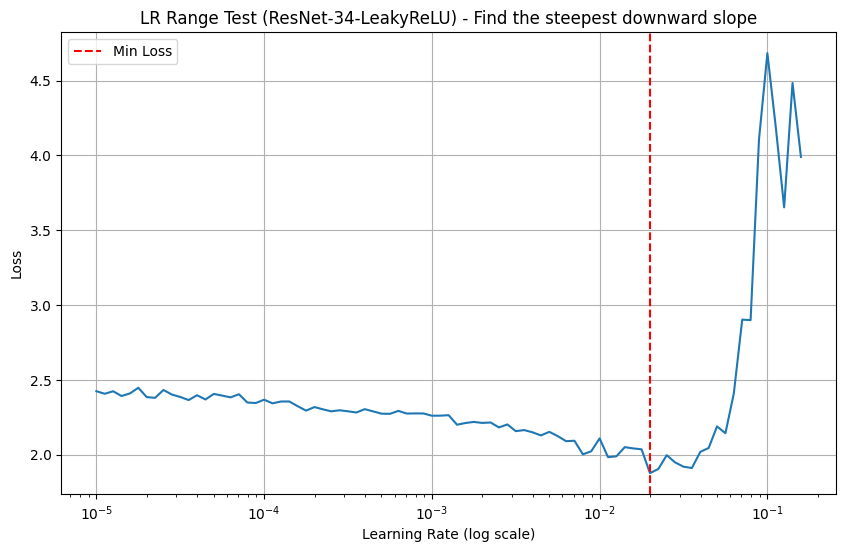


✓ LR Range Test Complete!
  Suggested LR: 0.112202
  Recommended range: 0.011220 to 0.112202

Using learning rate: 0.112202


In [ ]:
# LR Finder - Automatically find optimal learning rate (Leslie Smith Method)
def find_lr(trainloader, device, start_lr=1e-5, end_lr=1, num_iter=100, save_plot=True):
    """
    Leslie Smith's LR Range Test
    Gradually increases LR and plots loss to find optimal learning rate
    Note: Creates a fresh model to avoid modifying the main model
    """
    # Create fresh model for LR finding (matches training model)
    if use_deeper:
        test_model = resnet34_leaky()
    else:
        test_model = resnet18_leaky()
    
    test_model = test_model.to(device)
    test_model.train()
    
    test_criterion = nn.CrossEntropyLoss()
    test_optimizer = optim.SGD(test_model.parameters(), lr=start_lr, momentum=0.9, weight_decay=5e-4)
    
    lr_mult = (end_lr / start_lr) ** (1 / num_iter)
    lr = start_lr
    
    lrs = []
    losses = []
    best_loss = float('inf')
    
    print(f"Running LR Range Test with {model_name}...")
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        if batch_idx >= num_iter:
            break
            
        inputs, labels = inputs.to(device), labels.to(device)
        
        test_optimizer.zero_grad()
        outputs = test_model(inputs)
        loss = test_criterion(outputs, labels)
        
        # Stop if loss explodes
        if loss.item() > 4 * best_loss or torch.isnan(loss):
            print(f"Stopping early at iteration {batch_idx} - loss exploded")
            break
            
        if loss.item() < best_loss:
            best_loss = loss.item()
        
        losses.append(loss.item())
        lrs.append(lr)
        
        loss.backward()
        test_optimizer.step()
        
        lr *= lr_mult
        for param_group in test_optimizer.param_groups:
            param_group['lr'] = lr
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Loss')
    plt.title(f'LR Range Test ({model_name}) - Find the steepest downward slope')
    plt.grid(True)
    plt.axvline(x=lrs[np.array(losses).argmin()], color='r', linestyle='--', label='Min Loss')
    plt.legend()
    
    if save_plot:
        save_path = './plots/lr_range_test.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    
    # Find suggested LR (point of steepest descent)
    gradients = np.gradient(np.array(losses))
    min_grad_idx = gradients.argmin()
    suggested_lr = lrs[min_grad_idx]
    
    print(f"\n✓ LR Range Test Complete!")
    print(f"  Suggested LR: {suggested_lr:.6f}")
    print(f"  Recommended range: {suggested_lr/10:.6f} to {suggested_lr:.6f}")
    
    # Clean up
    del test_model, test_optimizer
    torch.cuda.empty_cache()
    
    return suggested_lr

# Run LR finder by default
use_lr_finder = True  # Set to False to skip LR finding

if use_lr_finder:
    suggested_lr = find_lr(trainloader, device, start_lr=1e-5, end_lr=1, num_iter=100, save_plot=True)
    learning_rate = suggested_lr  # Use the found LR
else:
    learning_rate = 0.1  # Default fallback
    suggested_lr = learning_rate

print(f"\nUsing learning rate: {learning_rate:.6f}")

In [ ]:
# Hyperparameters for this experiment
# learning_rate is set by LR finder above (or default 0.1)
momentum = 0.9
num_epochs = 200  # Extended training for better convergence
weight_decay = 5e-4  # L2 regularization

# Reinitialize model with fresh weights
if use_deeper:
    net = resnet34_leaky()
    model_name = 'ResNet-34-LeakyReLU'
else:
    net = resnet18_leaky()
    model_name = 'ResNet-18-LeakyReLU'

net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# LR Scheduler - Cosine Annealing
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-4)

# Enable Automatic Mixed Precision (AMP) for faster training
use_amp = torch.cuda.is_available()
scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

# Track experiment configuration
current_experiment = {
    'experiment_id': len(experiment_results) + 1,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_architecture': model_name,
    'optimizer': 'SGD',
    'learning_rate': learning_rate,
    'momentum': momentum,
    'weight_decay': weight_decay,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'lr_scheduler': 'CosineAnnealingLR',
    'augmentation': 'RandomCrop+HFlip+Cutout',
    'mixed_precision': use_amp,
    'device': str(device)
}

print(f"\nTraining Configuration:")
print(f"  Model: {model_name}")
print(f"  Learning Rate: {learning_rate:.6f} (with Cosine Annealing)")
print(f"  Epochs: {num_epochs}")
print(f"  Weight Decay: {weight_decay}")
print(f"  Batch Size: {batch_size}")
print(f"  Mixed Precision: {'Enabled' if use_amp else 'Disabled'}")


Training Configuration:
  Model: ResNet-34-LeakyReLU
  Learning Rate: 0.112202 (with Cosine Annealing)
  Epochs: 200
  Weight Decay: 0.0005
  Batch Size: 512
  Mixed Precision: Enabled


In [103]:
# Training loop with timing and AMP
print(f"Starting training on {device}...")
print(f"Mixed Precision (AMP): {'Enabled' if use_amp else 'Disabled'}")
training_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Automatic Mixed Precision forward pass
        with torch.amp.autocast('cuda', enabled=use_amp):
            outputs = net(inputs)
            loss = criterion(outputs, labels)
        
        # Scaled backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0
    
    # Step the learning rate scheduler
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch + 1}/{num_epochs} completed in {epoch_time:.2f}s | LR: {current_lr:.6f}")

training_time = time.time() - training_start_time
print(f'\nFinished training in {training_time:.2f}s ({training_time/60:.2f} minutes)')

# Store training time in experiment
current_experiment['training_time_seconds'] = training_time

Starting training on cuda...
Mixed Precision (AMP): Enabled
Epoch 1/200 completed in 5.22s | LR: 0.112195
Epoch 2/200 completed in 4.99s | LR: 0.112174
Epoch 3/200 completed in 4.84s | LR: 0.112140
Epoch 4/200 completed in 4.81s | LR: 0.112091
Epoch 5/200 completed in 3.19s | LR: 0.112029
Epoch 6/200 completed in 4.73s | LR: 0.111953
Epoch 7/200 completed in 4.81s | LR: 0.111863
Epoch 8/200 completed in 4.76s | LR: 0.111760
Epoch 9/200 completed in 4.79s | LR: 0.111643
Epoch 10/200 completed in 4.75s | LR: 0.111512
Epoch 11/200 completed in 4.75s | LR: 0.111367
Epoch 12/200 completed in 3.27s | LR: 0.111209
Epoch 13/200 completed in 4.77s | LR: 0.111037
Epoch 14/200 completed in 4.77s | LR: 0.110852
Epoch 15/200 completed in 4.81s | LR: 0.110653
Epoch 16/200 completed in 4.79s | LR: 0.110441
Epoch 17/200 completed in 4.81s | LR: 0.110215
Epoch 18/200 completed in 4.81s | LR: 0.109976
Epoch 19/200 completed in 3.39s | LR: 0.109724
Epoch 20/200 completed in 4.77s | LR: 0.109459
Epoch 21/

In [104]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Saved: ./plots/test_groundtruth_images.png


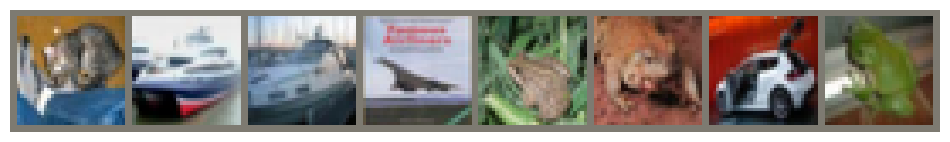

Groundtruth:  cat   ship  ship  plane frog  frog  car   frog 


In [116]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8]), save_path='./plots/test_groundtruth_images.png')
print('Groundtruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [ ]:
# Load the same architecture used for training
if use_deeper:
    net = resnet34_leaky()
else:
    net = resnet18_leaky()

net = net.to(device)
net.load_state_dict(torch.load(PATH, weights_only=True))
net.eval()
print(f'Model loaded successfully! ({model_name})')

Model loaded successfully! (ResNet-34-LeakyReLU)


In [107]:
# Move images to GPU for inference
images = images.to(device)
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  plane


Evaluating model on test set...
Accuracy of the network on the 10000 test images: 96.00%
Evaluation completed in 2.22s

Experiment #2 saved!

PER-CLASS ACCURACY
plane     :  964/1000 = 96.40%
car       :  984/1000 = 98.40%
bird      :  950/1000 = 95.00%
cat       :  909/1000 = 90.90%
deer      :  970/1000 = 97.00%
dog       :  932/1000 = 93.20%
frog      :  974/1000 = 97.40%
horse     :  974/1000 = 97.40%
ship      :  972/1000 = 97.20%
truck     :  971/1000 = 97.10%

Saved: ./plots/per_class_accuracy.png


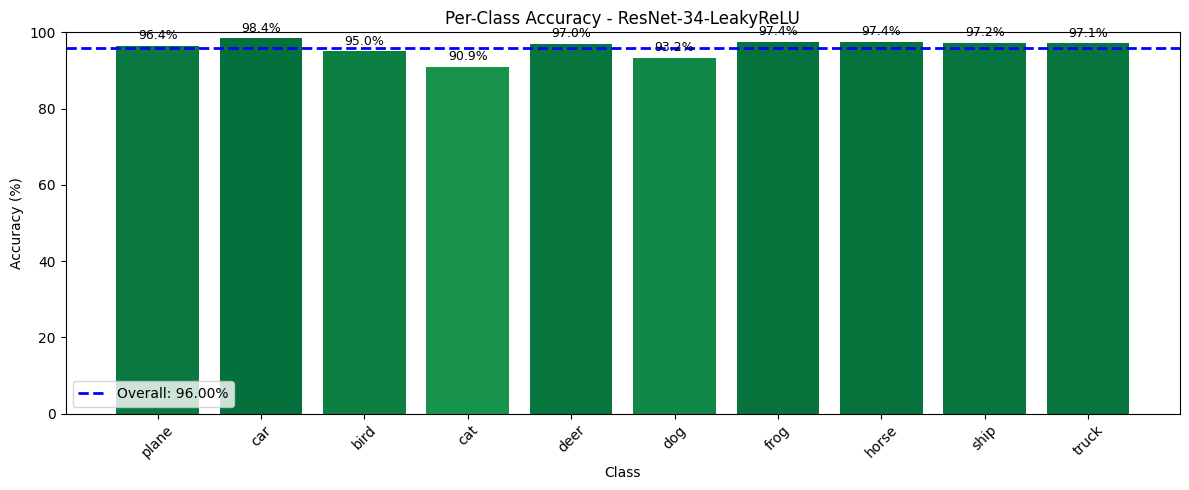


✓ Best class:  car (98.40%)
✗ Worst class: cat (90.90%)


In [117]:
# Evaluate on full test set
print("Evaluating model on test set...")
eval_start_time = time.time()

correct = 0
total = 0

# Per-class tracking
class_correct = {classname: 0 for classname in classes}
class_total = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Per-class accuracy
        for label, prediction in zip(labels, predicted):
            classname = classes[label]
            class_total[classname] += 1
            if label == prediction:
                class_correct[classname] += 1

eval_time = time.time() - eval_start_time
test_accuracy = 100 * correct / total

print(f'Accuracy of the network on the 10000 test images: {test_accuracy:.2f}%')
print(f'Evaluation completed in {eval_time:.2f}s')

# Store results in experiment tracker
current_experiment['test_accuracy'] = test_accuracy
current_experiment['eval_time_seconds'] = eval_time
current_experiment['correct_predictions'] = correct
current_experiment['total_test_samples'] = total

# Add to results list
experiment_results.append(current_experiment)
print(f"\nExperiment #{current_experiment['experiment_id']} saved!")

# Display per-class accuracy
print("\n" + "=" * 60)
print("PER-CLASS ACCURACY")
print("=" * 60)

per_class_data = []
for classname in classes:
    acc = 100 * class_correct[classname] / class_total[classname]
    per_class_data.append({
        'Class': classname,
        'Correct': class_correct[classname],
        'Total': class_total[classname],
        'Accuracy (%)': acc
    })
    print(f'{classname:10s}: {class_correct[classname]:4d}/{class_total[classname]:4d} = {acc:5.2f}%')

# Create DataFrame for visualization
per_class_df = pd.DataFrame(per_class_data)

# Plot per-class accuracy
plt.figure(figsize=(12, 5))
colors = plt.cm.RdYlGn(per_class_df['Accuracy (%)'] / 100)
bars = plt.bar(per_class_df['Class'], per_class_df['Accuracy (%)'], color=colors)
plt.axhline(y=test_accuracy, color='blue', linestyle='--', linewidth=2, label=f'Overall: {test_accuracy:.2f}%')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title(f'Per-Class Accuracy - {model_name}')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.legend()

# Add value labels on bars
for bar, acc in zip(bars, per_class_df['Accuracy (%)']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{acc:.1f}%', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Save the plot
save_path = './plots/per_class_accuracy.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"\nSaved: {save_path}")
plt.show()

# Show best and worst classes
best_class = per_class_df.loc[per_class_df['Accuracy (%)'].idxmax()]
worst_class = per_class_df.loc[per_class_df['Accuracy (%)'].idxmin()]
print(f"\n✓ Best class:  {best_class['Class']} ({best_class['Accuracy (%)']:.2f}%)")
print(f"✗ Worst class: {worst_class['Class']} ({worst_class['Accuracy (%)']:.2f}%)")

## Save/Load Experiment Results
Save experiment tracking data to CSV for persistence across sessions

In [113]:
# Save results to CSV
import os

csv_path = './experiment_results.csv'

# Convert current session results to DataFrame
if len(experiment_results) > 0:
    current_df = pd.DataFrame(experiment_results)
    
    # If file exists, load previous results and append
    if os.path.exists(csv_path):
        existing_df = pd.read_csv(csv_path)
        # Combine with current results, avoiding duplicates by timestamp
        all_results = pd.concat([existing_df, current_df]).drop_duplicates(subset=['timestamp'], keep='last')
        all_results.to_csv(csv_path, index=False)
        print(f"Updated {csv_path} with {len(current_df)} new experiment(s)")
    else:
        current_df.to_csv(csv_path, index=False)
        print(f"Created {csv_path} with {len(current_df)} experiment(s)")
    
    print(f"Total experiments saved: {len(pd.read_csv(csv_path))}")
else:
    print("No experiments to save. Run training and evaluation first!")

Updated ./experiment_results.csv with 3 new experiment(s)
Total experiments saved: 6


## View Experiment Results
Display all experiment runs in a table for comparison

In [114]:
# Display results as a DataFrame - including all saved experiments
import os

csv_path = './experiment_results.csv'

# Load all saved experiments from CSV if it exists
if os.path.exists(csv_path):
    all_experiments = pd.read_csv(csv_path)
    print(f"Loaded {len(all_experiments)} experiments from {csv_path}")
else:
    # Use current session results if no CSV exists
    all_experiments = pd.DataFrame(experiment_results)
    print("No saved experiments found. Showing current session only.")

# Reorder columns for better readability
column_order = [
    'experiment_id', 'timestamp', 'test_accuracy', 'model_architecture',
    'optimizer', 'learning_rate', 'momentum', 'weight_decay', 
    'batch_size', 'num_epochs', 'training_time_seconds', 'eval_time_seconds',
    'device', 'correct_predictions', 'total_test_samples'
]

# Only include columns that exist
column_order = [col for col in column_order if col in all_experiments.columns]
all_experiments = all_experiments[column_order]

# Sort by timestamp (most recent first)
if 'timestamp' in all_experiments.columns:
    all_experiments = all_experiments.sort_values('timestamp', ascending=False).reset_index(drop=True)

# Display the table
print("\n" + "=" * 150)
print("EXPERIMENT TRACKING TABLE - ALL RUNS")
print("=" * 150)

# Style the dataframe for better visualization
styled_df = all_experiments.style.background_gradient(
    subset=['test_accuracy'], 
    cmap='RdYlGn', 
    vmin=all_experiments['test_accuracy'].min() if len(all_experiments) > 0 else 0,
    vmax=all_experiments['test_accuracy'].max() if len(all_experiments) > 0 else 100
).format({
    'test_accuracy': '{:.2f}%',
    'training_time_seconds': '{:.2f}s',
    'eval_time_seconds': '{:.2f}s',
    'learning_rate': '{:.4f}',
    'momentum': '{:.2f}',
    'weight_decay': '{:.2e}'
})

display(styled_df)

# Show summary statistics
if len(all_experiments) > 0:
    print("\n" + "=" * 150)
    print("SUMMARY STATISTICS")
    print("=" * 150)
    print(f"Total Experiments: {len(all_experiments)}")
    print(f"Best Accuracy: {all_experiments['test_accuracy'].max():.2f}% (Experiment #{all_experiments.loc[all_experiments['test_accuracy'].idxmax(), 'experiment_id']:.0f})")
    print(f"Worst Accuracy: {all_experiments['test_accuracy'].min():.2f}%")
    print(f"Average Accuracy: {all_experiments['test_accuracy'].mean():.2f}%")
    print(f"Std Dev Accuracy: {all_experiments['test_accuracy'].std():.2f}%")
    print(f"Total Training Time: {all_experiments['training_time_seconds'].sum():.2f}s ({all_experiments['training_time_seconds'].sum()/60:.2f} min)")
    print(f"Average Training Time per Experiment: {all_experiments['training_time_seconds'].mean():.2f}s")
    
    # Show top 3 experiments
    print("\n" + "=" * 150)
    print("TOP 3 EXPERIMENTS BY ACCURACY")
    print("=" * 150)
    top_3 = all_experiments.nlargest(3, 'test_accuracy')[['experiment_id', 'timestamp', 'test_accuracy', 'model_architecture', 'learning_rate', 'batch_size', 'num_epochs']]
    display(top_3)
else:
    print("\nNo experiments to display yet. Run training first!")

Loaded 6 experiments from ./experiment_results.csv

EXPERIMENT TRACKING TABLE - ALL RUNS


,experiment_id,timestamp,test_accuracy,model_architecture,optimizer,learning_rate,momentum,weight_decay,batch_size,num_epochs,training_time_seconds,eval_time_seconds,device,correct_predictions,total_test_samples
0,2,2026-02-02 11:45:29,96.00%,ResNet-34-LeakyReLU,SGD,0.1122,0.90,5.00e-04,512,200,925.38s,2.18s,cuda,9600,10000
1,1,2026-02-02 10:48:45,10.00%,WideResNet-28-10,SGD,0.6310,0.90,5.00e-04,512,200,3081.13s,2.12s,cuda,1000,10000
2,1,2026-02-02 10:22:21,86.34%,ResNet18 with LeakyReLU,SGD,0.0100,0.90,5.00e-04,128,100,591.10s,0.99s,cuda,8634,10000
3,1,2026-02-02 09:59:39,67.35%,"Basic CNN (2 conv, 3 fc)",SGD,0.0010,0.90,0.00e+00,128,100,591.44s,0.91s,cuda,6735,10000
4,1,2026-02-02 09:29:38,65.74%,"Basic CNN (2 conv, 3 fc)",SGD,0.0010,0.90,0.00e+00,64,50,187.83s,0.82s,cuda,6574,10000
5,1,2026-02-02 09:21:38,51.88%,"Basic CNN (2 conv, 3 fc)",SGD,0.0010,0.90,0.00e+00,4,2,88.53s,4.94s,cuda,5188,10000



SUMMARY STATISTICS
Total Experiments: 6
Best Accuracy: 96.00% (Experiment #2)
Worst Accuracy: 10.00%
Average Accuracy: 62.88%
Std Dev Accuracy: 30.31%
Total Training Time: 5465.41s (91.09 min)
Average Training Time per Experiment: 910.90s

TOP 3 EXPERIMENTS BY ACCURACY


,experiment_id,timestamp,test_accuracy,model_architecture,learning_rate,batch_size,num_epochs
0,2,2026-02-02 11:45:29,96.00,ResNet-34-LeakyReLU,0.112202,512,200
2,1,2026-02-02 10:22:21,86.34,ResNet18 with LeakyReLU,0.010000,128,100
3,1,2026-02-02 09:59:39,67.35,"Basic CNN (2 conv, 3 fc)",0.001000,128,100
